# Building Agents 
 
> Note: Optionally, see [these slides](https://docs.google.com/presentation/d/13c0L1CQWAL7fuCXakOqjkvoodfynPJI4Hw_4H76okVU/edit?usp=sharing) and [langgraph_101.ipynb](langgraph_101.ipynb) for context before diving into this notebook!

We're going to build an email assistant from scratch, starting here with 1) the agent architecture (using [LangGraph](https://langchain-ai.github.io/langgraph/)) and following with 2) testing (using [LangSmith](https://docs.smith.langchain.com/)), 3) human-in-the-loop, and 4) memory. This diagram show how these pieces will fit together:

![overview-img](img/overview.png)

#### Load environment variables

In [1]:
from typing import Literal
from datetime import datetime
from pydantic import BaseModel
from langchain_core.tools import tool
from langgraph.graph import MessagesState
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from email_assistant.utils import parse_email, format_email_markdown
from langchain.chat_models import init_chat_model
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph
from langgraph.types import Command
from IPython.display import Markdown, display, Image
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.messages import HumanMessage, SystemMessage, ToolMessage
from email_assistant.tools.default.prompt_templates import AGENT_TOOLS_PROMPT
from email_assistant.prompts import agent_system_prompt, default_response_preferences, default_cal_preferences
from email_assistant.prompts import triage_system_prompt, triage_user_prompt, default_triage_instructions, default_background

load_dotenv()

True

## Tool Definition

Let's start by defining some simple tools that an email assistant will use with the `@tool` decorator:

In [2]:
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

@tool
def schedule_meeting(
    attendees: list[str],
    subject: str,
    duration_minutes: int,
    preferred_day: datetime,
    start_time: str,
) -> str:
    """Schedule a calendar meeting."""
    date_str = preferred_day.strftime("%A, %B %d, %Y")
    return f"Meeting '{subject}' scheduled on {date_str} at {start_time} for {duration_minutes} minutes with {len(attendees)} attendees"

@tool
def check_calendar_availability(day: datetime) -> str:
    """Check calendar availability for a given day."""
    return f"Available time slots for {day.strftime('%A, %B %d, %Y')}:\n- 9:00 AM\n- 10:00 AM\n- 11:00 AM"

class Done(BaseModel):
    """Call this when you have fully handled the email (e.g., replied or no action needed)."""
    done: bool = Field(default=True, description="Confirms task completion")

In [3]:
tools = [write_email, schedule_meeting, check_calendar_availability, Done]
tool_node = ToolNode(tools)

## Building our email assistant

We'll combine a [router and agent](https://langchain-ai.github.io/langgraph/tutorials/workflows/) to build our email assistant.

![agent_workflow_img](img/email_workflow.png)

### Router

The routing step handles the triage decision. 

The triage router only focuses on the triage decision, while the agent focuses *only* on the response. 

#### State

When building an agent, it's important to consider the information that you want to track over time. We'll use LangGraph's pre-built [`MessagesState` object](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate), which is a just dictionary with a `messages` key that appends messages returned by nodes [as its update logic](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers). However, LangGraph gives you flexibility to track other information. We'll define a custom `State` object that extends `MessagesState` and adds a `classification_decision` key:

#### Triage node

We define a python function with our triage routing logic.

For this, we use [structured outputs](https://python.langchain.com/docs/concepts/structured_outputs/) with a Pydantic model, which is particularly useful for defining structured output schemas because it offers type hints and validation. The descriptions in the pydantic model are important because they get passed as part JSON schema to the LLM to inform the output coercion.

In [4]:
Markdown(triage_system_prompt)



< Role >
Your role is to triage incoming emails based upon instructs and background information below.
</ Role >

< Background >
{background}. 
</ Background >

< Instructions >
Categorize each email into one of three categories:
1. IGNORE - Emails that are not worth responding to or tracking
2. NOTIFY - Important information that worth notification but doesn't require a response
3. RESPOND - Emails that need a direct response
Classify the below email into one of these categories.
</ Instructions >

< Rules >
{triage_instructions}
</ Rules >


In [5]:
Markdown(triage_user_prompt)


Please determine how to handle the below email thread:

From: {author}
To: {to}
Subject: {subject}
{email_thread}

In [6]:
Markdown(default_background)

 
I'm Lance, a software engineer at LangChain.


In [7]:
Markdown(default_triage_instructions)


Emails that are not worth responding to:
- Marketing newsletters and promotional emails
- Spam or suspicious emails
- CC'd on FYI threads with no direct questions

There are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:
- Team member out sick or on vacation
- Build system notifications or deployments
- Project status updates without action items
- Important company announcements
- FYI emails that contain relevant information for current projects
- HR Department deadline reminders
- Subscription status / renewal reminders
- GitHub notifications

Emails that are worth responding to:
- Direct questions from team members requiring expertise
- Meeting requests requiring confirmation
- Critical bug reports related to team's projects
- Requests from management requiring acknowledgment
- Client inquiries about project status or features
- Technical questions about documentation, code, or APIs (especially questions about missing endpoints or features)
- Personal reminders related to family (wife / daughter)
- Personal reminder related to self-care (doctor appointments, etc)


In [8]:
Markdown(triage_system_prompt.format(
    background=default_background,
    triage_instructions=default_triage_instructions
))



< Role >
Your role is to triage incoming emails based upon instructs and background information below.
</ Role >

< Background >
 
I'm Lance, a software engineer at LangChain.
. 
</ Background >

< Instructions >
Categorize each email into one of three categories:
1. IGNORE - Emails that are not worth responding to or tracking
2. NOTIFY - Important information that worth notification but doesn't require a response
3. RESPOND - Emails that need a direct response
Classify the below email into one of these categories.
</ Instructions >

< Rules >

Emails that are not worth responding to:
- Marketing newsletters and promotional emails
- Spam or suspicious emails
- CC'd on FYI threads with no direct questions

There are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:
- Team member out sick or on vacation
- Build system notifications or deployments
- Project status updates without action items
- Important company announcements
- FYI emails that contain relevant information for current projects
- HR Department deadline reminders
- Subscription status / renewal reminders
- GitHub notifications

Emails that are worth responding to:
- Direct questions from team members requiring expertise
- Meeting requests requiring confirmation
- Critical bug reports related to team's projects
- Requests from management requiring acknowledgment
- Client inquiries about project status or features
- Technical questions about documentation, code, or APIs (especially questions about missing endpoints or features)
- Personal reminders related to family (wife / daughter)
- Personal reminder related to self-care (doctor appointments, etc)

</ Rules >


In [9]:
Markdown(AGENT_TOOLS_PROMPT)


1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day, start_time) - Schedule calendar meetings where preferred_day is a datetime object
3. check_calendar_availability(day) - Check available time slots for a given day
4. Done - E-mail has been sent


In [10]:
Markdown(agent_system_prompt)


< Role >
You are a top-notch executive assistant who cares about helping your executive perform as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage communications and schedule:
{tools_prompt}
</ Tools >

< Instructions >
When handling emails, follow these steps:
1. Carefully analyze the email content and purpose
2. IMPORTANT --- always call a tool and call one tool at a time until the task is complete: 
3. For responding to the email, draft a response email with the write_email tool
4. For meeting requests, use the check_calendar_availability tool to find open time slots
5. To schedule a meeting, use the schedule_meeting tool with a datetime object for the preferred_day parameter
   - Today's date is 2026-01-09 - use this for scheduling meetings accurately
6. If you scheduled a meeting, then draft a short response email using the write_email tool
7. After using the write_email tool, the task is complete
8. If you have sent the email, then use the Done tool to indicate that the task is complete
</ Instructions >

< Background >
{background}
</ Background >

< Response Preferences >
{response_preferences}
</ Response Preferences >

< Calendar Preferences >
{cal_preferences}
</ Calendar Preferences >


In [11]:
Markdown(agent_system_prompt.format(
    tools_prompt=AGENT_TOOLS_PROMPT,
    background=default_background,
    response_preferences=default_response_preferences,
    cal_preferences=default_cal_preferences
))


< Role >
You are a top-notch executive assistant who cares about helping your executive perform as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day, start_time) - Schedule calendar meetings where preferred_day is a datetime object
3. check_calendar_availability(day) - Check available time slots for a given day
4. Done - E-mail has been sent

</ Tools >

< Instructions >
When handling emails, follow these steps:
1. Carefully analyze the email content and purpose
2. IMPORTANT --- always call a tool and call one tool at a time until the task is complete: 
3. For responding to the email, draft a response email with the write_email tool
4. For meeting requests, use the check_calendar_availability tool to find open time slots
5. To schedule a meeting, use the schedule_meeting tool with a datetime object for the preferred_day parameter
   - Today's date is 2026-01-09 - use this for scheduling meetings accurately
6. If you scheduled a meeting, then draft a short response email using the write_email tool
7. After using the write_email tool, the task is complete
8. If you have sent the email, then use the Done tool to indicate that the task is complete
</ Instructions >

< Background >
 
I'm Lance, a software engineer at LangChain.

</ Background >

< Response Preferences >

Use professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and reference the deadline in your response.

When responding to technical questions that require investigation:
- Clearly state whether you will investigate or who you will ask
- Provide an estimated timeline for when you'll have more information or complete the task

When responding to event or conference invitations:
- Always acknowledge any mentioned deadlines (particularly registration deadlines)
- If workshops or specific topics are mentioned, ask for more specific details about them
- If discounts (group or early bird) are mentioned, explicitly request information about them
- Don't commit 

When responding to collaboration or project-related requests:
- Acknowledge any existing work or materials mentioned (drafts, slides, documents, etc.)
- Explicitly mention reviewing these materials before or during the meeting
- When scheduling meetings, clearly state the specific day, date, and time proposed

When responding to meeting scheduling requests:
- If times are proposed, verify calendar availability for all time slots mentioned in the original email and then commit to one of the proposed times based on your availability by scheduling the meeting. Or, say you can't make it at the time proposed.
- If no times are proposed, then check your calendar for availability and propose multiple time options when available instead of selecting just one.
- Mention the meeting duration in your response to confirm you've noted it correctly.
- Reference the meeting's purpose in your response.

</ Response Preferences >

< Calendar Preferences >

30 minute meetings are preferred, but 15 minute meetings are also acceptable.

</ Calendar Preferences >


### Agent

Now, let's build the agent.

#### LLM node

Here, we define the LLM decision-making node. This node takes in the current state, calls the LLM, and updates `messages` with the LLM output. 

We [enforce tool use with OpenAI](https://python.langchain.com/docs/how_to/tool_choice/) by setting `tool_choice="required"`.

In [12]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tools = llm.bind_tools(tools)

In [13]:
class ResponseState(MessagesState):
    """ The state of the response agent. """
    pass

In [14]:
def response_agent_node(state: ResponseState):
    system_prompt = agent_system_prompt.format(
        tools_prompt=AGENT_TOOLS_PROMPT,
        background=default_background,
        response_preferences=default_response_preferences,
        cal_preferences=default_cal_preferences,
    )
    response = llm_with_tools.invoke(
        [{"role": "system", "content": system_prompt}] + state["messages"]
    )
    return {"messages": [response]}

#### Agent Graph

Finally, we can assemble all components:

This creates a graph that:
1. Starts with an LLM decision
2. Conditionally routes to tool execution or termination
3. After tool execution, returns to LLM for the next decision
4. Repeats until completion or no tool is called


In [15]:
# Build the response subgraph
response_graph = StateGraph(ResponseState)

response_graph.add_node("agent", response_agent_node)
response_graph.add_node("tools", tool_node)

response_graph.add_edge(START, "agent")
response_graph.add_conditional_edges(
    "agent",
    tools_condition,  # → "tools" if tool calls, else END (when Done or no tools)
)
response_graph.add_edge("tools", "agent")

response_agent_subgraph = response_graph.compile()

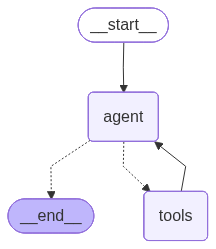

In [16]:
display(Image(response_agent_subgraph.get_graph(xray=1).draw_mermaid_png()))

### Combine workflow with our agent

We can combine the router and the agent.

This is a higher-level composition where:
1. First, the triage router analyzes the email
2. If needed, the response agent handles crafting a response
3. The workflow ends when either the triage decides no response is needed or the response agent completes

In [17]:
class RouteSchema(BaseModel):
    reasoning: str = Field(description="Step-by-step reasoning behind the classification.")
    classification_decision: Literal["ignore", "notify", "respond"] = Field(
        description="Classify as 'ignore', 'notify', or 'respond'."
    )

In [18]:
llm_router = llm.with_structured_output(RouteSchema)

In [19]:
class MainState(MessagesState):
    email_input: dict
    classification_decision: str
    reasoning: str

In [20]:
def email_classifier(state: MainState):
    """ Classify the email based on its content. """

    author, to, subject, email_thread = parse_email(state["email_input"])

    system_msg = SystemMessage(content=triage_system_prompt.format(
        background=default_background,
        triage_instructions=default_triage_instructions
    ))
    user_msg = HumanMessage(content=triage_user_prompt.format(
        author=author, to=to, subject=subject, email_thread=email_thread
    ))

    result = llm_router.invoke([system_msg, user_msg])

    decision = result.classification_decision

    if decision == "respond":
        print("Classification: RESPOND - This email requires a response")
        return {
            "messages": [HumanMessage(
                content=f"Respond to this email:\n\n{format_email_markdown(subject, author, to, email_thread)}"
            )],
            "classification_decision": decision,
            "reasoning": result.reasoning,
        }
    else:
        # ignore or notify → just log and end
        status = "IGNORE" if decision == "ignore" else "NOTIFY"
        print(f"Classification: {status} - {result.reasoning}")
        return {
            "classification_decision": decision,
            "reasoning": result.reasoning,
        }

In [21]:
email_input = {
    'author': 'System Admin <sysadmin@company.com>',
    'to': 'Development Team <dev@company.com>',
    'subject': 'Scheduled maintenance - database downtime',
    'email_thread': "Hi team,\n\nThis is a reminder that we'll be performing scheduled maintenance on the production database tonight from 2AM to 4AM EST. During this time, all database services will be unavailable.\n\nPlease plan your work accordingly and ensure no critical deployments are scheduled during this window.\n\nThanks,\nSystem Admin Team"
}

author, to, subject, email_thread = parse_email(email_input)

Markdown(triage_user_prompt.format(
    author=author, to=to, subject=subject, email_thread=email_thread
))


Please determine how to handle the below email thread:

From: System Admin <sysadmin@company.com>
To: Development Team <dev@company.com>
Subject: Scheduled maintenance - database downtime
Hi team,

This is a reminder that we'll be performing scheduled maintenance on the production database tonight from 2AM to 4AM EST. During this time, all database services will be unavailable.

Please plan your work accordingly and ensure no critical deployments are scheduled during this window.

Thanks,
System Admin Team

In [22]:
classification = email_classifier({
    "email_input": email_input
})

Classification: NOTIFY - The email is a notification about scheduled maintenance on the production database, which is important information for the development team to be aware of. It does not require a response, but it is crucial for planning work and avoiding critical deployments during the downtime.


In [23]:
for i in classification:
    display(Markdown(f"**{i.capitalize()}**: {classification[i]}"))

**Classification_decision**: notify

**Reasoning**: The email is a notification about scheduled maintenance on the production database, which is important information for the development team to be aware of. It does not require a response, but it is crucial for planning work and avoiding critical deployments during the downtime.

In [24]:
# Route based on classification
def route_after_classification(state: MainState) -> str:
    if state["classification_decision"] == "respond":
        return "response_agent"
    return END

In [25]:
main_workflow = StateGraph(MainState)

main_workflow.add_node("email_classifier", email_classifier)
main_workflow.add_node("response_agent", response_agent_subgraph)

main_workflow.add_edge(START, "email_classifier")

main_workflow.add_conditional_edges(
    "email_classifier",
    route_after_classification,
    {
        "response_agent": "response_agent",
        END: END,
    },
)

# When response agent finishes (via Done tool), go to END
main_workflow.add_edge("response_agent", END)

# Compile final agent
main_agent = main_workflow.compile()

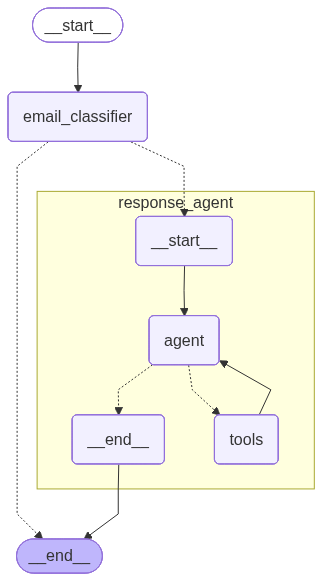

In [26]:
display(Image(main_agent.get_graph(xray=1).draw_mermaid_png()))

This is a higher-level composition where:

- First, the triage router analyzes the email
- If needed, the response agent handles crafting a response
- The workflow ends when either the triage decides no response is needed or the response agent completes

In [27]:
email_input = {
    "author": "System Admin <sysadmin@company.com>",
    "to": "Development Team <dev@company.com>",
    "subject": "Scheduled maintenance - database downtime",
    "email_thread": "Hi team,\n\nThis is a reminder that we'll be performing scheduled maintenance on the production database tonight from 2AM to 4AM EST. During this time, all database services will be unavailable.\n\nPlease plan your work accordingly and ensure no critical deployments are scheduled during this window.\n\nThanks,\nSystem Admin Team"
}

# Initial state
initial_state = {
    "email_input": email_input
}

In [28]:
# Run
result = main_agent.invoke(initial_state)

# Print final messages
print("\n=== Final Output ===")
for msg in result["messages"]:
    msg.pretty_print()

Classification: NOTIFY - The email is a notification about scheduled maintenance on the production database, which is important information for the development team to be aware of. It does not require a response, but it is crucial for planning work and avoiding critical deployments during the downtime.

=== Final Output ===


In [30]:
email_input = {
  "author": "Alice Smith <alice.smith@company.com>",
  "to": "John Doe <john.doe@company.com>",
  "subject": "Quick question about API documentation",
  "email_thread": "Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice"
}

In [32]:
# Run
result = main_agent.invoke({
    "email_input": email_input
})

# Print final messages
# print("\n=== Final Output ===")
# for msg in result["messages"]:
#     msg.pretty_print()

Classification: RESPOND - This email requires a response


In [38]:
# Print final messages
print("\n=== Final Output ===")
for msg in result["messages"]:
    msg.pretty_print()


=== Final Output ===
================================ Human Message =================================

Respond to this email:



**Subject**: Quick question about API documentation
**From**: Alice Smith <alice.smith@company.com>
**To**: John Doe <john.doe@company.com>

Hi John,
I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?
Specifically, I'm looking at:
- /auth/refresh
- /auth/validate
Thanks!
Alice

---

================================== Ai Message ==================================
Tool Calls:
  write_email (call_QotWOewV5RIH1x6zcHzV5jbq)
 Call ID: call_QotWOewV5RIH1x6zcHzV5jbq
  Args:
    to: alice.smith@company.com
    subject: Re: Quick question about API documentation
    content: Hi Alice,

Thank you for bringing this to my attention. I will investigate the missing endpoints, /auth/refresh and /auth/validate, t

## Testing with Local Deployment

You can find the file for our agent in the `src/email_assistant` directory:

* `src/email_assistant/email_assistant.py`

You can test them locally in LangGraph Studio by running:

```
! langgraph dev
```

Example e-mail you can test:

In [ ]:
{
  "author": "Alice Smith <alice.smith@company.com>",
  "to": "John Doe <john.doe@company.com>",
  "subject": "Quick question about API documentation",
  "email_thread": "Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice"
}